# Load main libraries

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import string
import matplotlib.pyplot as plt
import seaborn as sns 
sns.set() # use seaborn for better plots


"""
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
"""

#---this can be used for craeting zoomable matplotlib plots.
#---but it makes the notebook handling slow (e.g. not so smooth scroll)
#import mpld3
#mpld3.enable_notebook()

#%matplotlib inline
# ---------------------------------

Read file Time_DipTilt_Dipl11_equispaced_standardized.csv


# Equispaced time series
This function converts an irregular time series (i.e. variable time stepping) to equispaced regular time series

In [ ]:
def equispaced_time(in_time, out_time, signal):
    equi_out_time = np.linspace(out_time[0], out_time[-1], len(out_time))
    out_data = np.interp(equi_out_time, in_time, signal)
    return out_data

# Load data
Here we read the data. 

If a .csv data file is present, then it reads it directly. 

Else, it reads the dipole.tag files produced by the MagIC code.

**Equispaced and standardized (mean 0) time series is produced by default.**

**The start time of the time series is forced to 0 by default.**

In [ ]:
os.chdir('/home/ryadav/Meduri_reversals/dipole_files')

fname = 'Time_DipTilt_Dipl11_equispaced_standardized.csv'

if os.path.isfile(fname):
    df = pd.read_csv(fname)
    print('Read file', fname)
else:
    atoz = string.ascii_lowercase
    tags = ['BM+Ra5e5'+letter+str(integer) for integer in [5, 6, 7] for letter in atoz]

    num_files = -1
    standard = True

    tags = tags[0:num_files]
    
    #read dipole.tag files, a bit messy since data is in fortran 'D' notation
    for ind, item in enumerate(tags):
        print(ind, item)
        fname = 'dipole.'+item
        f = open(fname, 'r')
        X = []
        for k, line in enumerate(f.readlines()):
            st = line.replace('D', 'e')
            X.append(st.split())
        X = np.asarray(X, dtype=float)
        f.close()

        time = np.linspace(X[0,0], X[-1,0], X.shape[0])
        # dipole tilt angle wrt tothe rotation axis
        dip_tilt = equispaced_time(X[:,0], X[:,0], X[:,1])
        # convert from [0,180] to [90,-90]
        dip_tilt += -90 
        # l=1 (axial dipole) strength compared to l up to 11
        dip_l11 = equispaced_time(X[:,0], X[:,0], X[:,5]) 

        if ind==0:
            df  = pd.DataFrame({'time':time, 'dipole_tilt':dip_tilt, 'dip_l11':dip_l11}, dtype=np.float32)
        else:
            df2 = pd.DataFrame({'time':time, 'dipole_tilt':dip_tilt, 'dip_l11':dip_l11}, dtype=np.float32)

            df = df.append(df2, ignore_index=True)

    # rescale time to -> 0 -- t
    df['time'] = df['time']-df['time'].min() 

    # perform standardization 
    if standard==True:
        from sklearn.preprocessing import StandardScaler
        scaled_features = StandardScaler().fit_transform(df[['dipole_tilt', 'dip_l11']].values)
        #print(scaled_features.shape)
        df['dipole_tilt'] = scaled_features[:,0]
        df['dip_l11'] = scaled_features[:,1]

OPTIONAL: can be used for storing data to csv is read from dipole.tag files in the above section

In [2]:
# for saving data
#df[['time','dipole_tilt']].to_csv('Time_DipTilt_equispaced_standardized.csv', index=False)
#df.to_csv('Time_DipTilt_Dipl11_equispaced_standardized.csv', index=False)

# Plot a small section of the data

(5764077, 3)


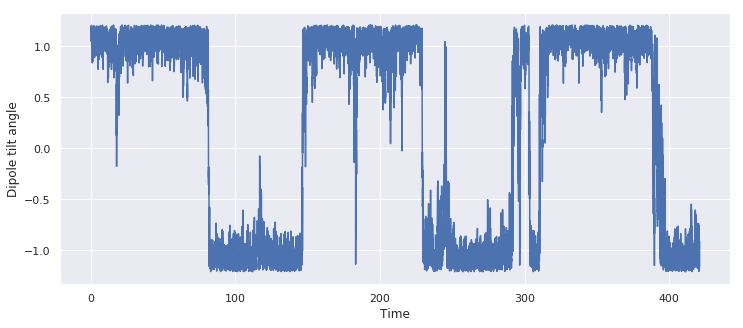

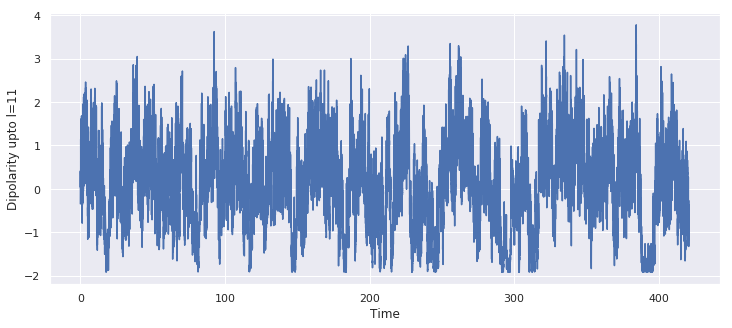

In [3]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df['time'][0:70000], df['dipole_tilt'][0:70000])
plt.xlabel('Time')
plt.ylabel('Dipole tilt angle')

fig, ax = plt.subplots(figsize=(12,5))
plt.plot(df['time'][0:70000], df['dip_l11'][0:70000])
plt.xlabel('Time')
plt.ylabel('Dipolarity upto l=11')


print(df.shape)

# FFT based smoothing function
Takes a dataframe as input and the strength of the smoothing required.

In [12]:
def smooth_data(df_main, low_pass_strength=1):

    # low pass filter the data
    from scipy.signal import butter, filtfilt, freqz

    def butter_lowpass(cutoff, fs, order=3):
        nyq = 0.5 * fs
        normal_cutoff = cutoff / nyq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        return b, a

    def butter_lowpass_filter(data, cutoff, fs, order=3):
        b, a = butter_lowpass(cutoff, fs, order=order)
        y = filtfilt(b, a, data)
        return y


    order = 6
    fs = 10.0  # sample rate
    # severity of the smoothing, higher val, higher smoothing
    cutoff = 1/(low_pass_strength+1.0) 

    df_smooth = pd.DataFrame(index=df_main.index,columns=df_main.columns)

    df_smooth['time'] = butter_lowpass_filter(df_main['time'].values, cutoff, fs, order)
    df_smooth['dipole_tilt'] = butter_lowpass_filter(df_main['dipole_tilt'].values, cutoff, fs, order)
    df_smooth['dip_l11'] = butter_lowpass_filter(df_main['dip_l11'].values, cutoff, fs, order)    
    
    fig, ax = plt.subplots(figsize=(12,5))
    plt.plot(df_main['time'], df_main['dipole_tilt'], 'r.', label='Original')
    plt.plot(df_main['time'].values, df_main['dipole_tilt'].values, 'r-')
    plt.plot(df_smooth['time'], df_smooth['dipole_tilt'], 'b.', label='Smoothed')
    plt.plot(df_smooth['time'].values, df_smooth['dipole_tilt'].values, 'b-')
    plt.xlabel('Time')
    plt.ylabel('Dipole tilt angle')
    plt.legend()
    plt.xlim([200,200.5])
    plt.ylim([0.5,1.5])
    
    return df_smooth


# Function to increase the time resolution of a series
Takesh a data frames and the fcator by which to increase the time resolution

In [ ]:
# use interpolation to increase time resulutio
# may be useful for capturing rapid equator crossings
def increase_time_res(df_main, factor=2):
    
    df_out = pd.DataFrame(np.nan, 
                          index = np.arange(df_main.shape[0]*factor), 
                          columns = df_main.columns,
                          dtype=np.float32)
    
    df_out['time'] = np.linspace(df_main['time'].values[0], df_main['time'].values[-1], df_out.shape[0])
    df_out['dipole_tilt'] = equispaced_time(df_main['time'].values, df_out['time'].values, df_main['dipole_tilt'].values)
    df_out['dip_l11'] = equispaced_time(df_main['time'].values, df_out['time'].values, df_main['dip_l11'].values)
    
    #print(df_main['time'].values[0])
    return df_out


# Get and classify the zero (i.e. equator) crossings
Extract and then classify zero (or 'equator' in geodynamo terminology) crossings as reversals and excursions. A Reversal event (labelled '1') is when the time series suddenly goes from +ve to -ve (or vice versa) values. An Excursion event (labelled '0') is when it fails to change sign and comes back to being +ve or -ve.

Since the time series is discrete, no data point in time is exactly 0 (i.e. at the equator). So we define a belt or zone, defined by latitudinal threshol **lat_thres** parameter to tell the function if something has crossed the equator. **lat_thres** essentially defines the latidude range (in *standardized* latitudes ranging from about 0 to 1 in one hemisphere) around the equator.

The **pad_size** (in number of points) defines a narrow window of time centered around the Reversal/Excursion event. An event will defined by this window.

Since the time series is chaotic, some of the events can be very messy. The function uses the standard deviation of series in the left and right padding to define how messy the time series is. We can use a threshold **std_thres** value to pick cleaner events.

The function adds *nature*, *left_std* and *right_std* columns to the input data frame.

An even is 1 (Reversal) if the means of left and right padding series are opposite, and 0 otherwise.

In [6]:
def get_EqCros(df_main, pad_size=1500, std_thres=0.2, lat_thres=0.1):
    
    # get equator crossing times
    cond = (df_main['dipole_tilt']>-lat_thres) & (df_main['dipole_tilt']<lat_thres)
    df_EquCross  = df_main.loc[cond]

    # Clean df_EquCross to remove very close data points.
    # First get the indices to drop from the df
    drop_indices=[]
    for i in range(df_EquCross.shape[0]-1):
        #check following 5 points for proximity
        for j in range(5):
            if i+j+1 < df_EquCross.shape[0]: # avoid issue at the end point of df_EquCross
                if df_EquCross.index[i+j+1] - df_EquCross.index[i] < pad_size:
                    drop_indices.append(df_EquCross.index[i+j+1])

    df_EquCross.drop(drop_indices, inplace=True)

    # Add new columns containing the nature and standard deviation of dipole 
    # tilt in the left and right paddings of the equator crossing times
    df_EquCross['nature'] = pd.Series(np.zeros(df_EquCross.shape[0]), 
                                      index=df_EquCross.index, 
                                      dtype=int)
    df_EquCross['left_std'] = pd.Series(np.zeros(df_EquCross.shape[0]), 
                                      index=df_EquCross.index, 
                                      dtype=float)
    df_EquCross['right_std'] = pd.Series(np.zeros(df_EquCross.shape[0]), 
                                      index=df_EquCross.index, 
                                      dtype=float)
    
    # get nature of equtor crossings
    for i in range(df_EquCross.shape[0]): 
        LeftInds = [df_EquCross.index[i]-j for j in range(pad_size)]
        LeftSum = df_main.iloc[LeftInds]['dipole_tilt'].sum()/pad_size
        # access elements by '.at' function -> df.at[index, column]
        df_EquCross.at[df_EquCross.index[i], 'left_std'] = df_main.iloc[LeftInds]['dipole_tilt'].std()

        # Summing on the right hand side padding may cause issues if the last 
        # equator crossing is being considered.
        # So, shrink the padding size equal to the no. of last available points
        # at the end of the series
        if i == df_EquCross.shape[0] - 1: # basically, last iteration
            pad_size_temp = df_main.index[-1] - df_EquCross.index[i]
        else:
            pad_size_temp = pad_size

        RightInds = [df_EquCross.index[i]+j for j in range(pad_size_temp)]
        RightSum = df_main.iloc[RightInds]['dipole_tilt'].sum()/pad_size_temp
        df_EquCross.at[df_EquCross.index[i], 'right_std'] = df_main.iloc[RightInds]['dipole_tilt'].std()

        if LeftSum*RightSum > 0:
            # access elements by '.at' function -> df.at[index, column]
            df_EquCross.at[df_EquCross.index[i], 'nature'] = 0
        else:
            df_EquCross.at[df_EquCross.index[i], 'nature'] = 1

    # use std threshold for selecting cleaner reversals/excursions
    cond2 = (df_EquCross['left_std']<std_thres) & (df_EquCross['right_std']<std_thres)
    df_EquCross_clean = df_EquCross[cond2]

    return df_EquCross_clean

# Cook data for machine learning
Prepare data as a series of events which be fed to ML functions. 

output -> (num of events, pad_size, num of features), (labels)

We have left and right paddings around an event. We call the left padding as one data point. Since the underlying equations are immune to t -> -t transformation (i.e. equations behave the same if we were to go backwards in time) we also threat the right padding as an event by assuming we will also get the same nature of the event if we went backward in time from right to left. The right padding time series is flipped is time as if we were going forward in time to make both left and right paddings similar in behavior. 

We also make sure that both left and right paddings go from +ve to 0 for consistency.

In [13]:
def cook_data(df_main, df_EqCros, pad_size=1500):
    X_data = []
    y_data = []
    for i in range(df_EqCros.shape[0]-1): # Skipping the last data point.
                                          # Right padding may be smaller than pad size
        
        LeftInds = [df_EqCros.index[i]-pad_size+j for j in range(pad_size)]
        # convert South latitudes to North for consistent dataset
        if df_main.iloc[LeftInds]['dipole_tilt'].mean()<0:
            X_data.append(  [-1.0*df_main.iloc[LeftInds]['dipole_tilt'], 
                                  df_main.iloc[LeftInds]['dip_l11'    ]  ] )
        else:
            X_data.append(  [     df_main.iloc[LeftInds]['dipole_tilt'], 
                                  df_main.iloc[LeftInds]['dip_l11'    ]  ] )
        y_data.append(df_EqCros.iloc[i]['nature'])
        
        # Since system is immune to t <-> -t, data on the right of 
        # equator crossing can also be taken as a data point.
        # Note: flip('::-1') the data on right so that it is consistent 
        # with data on the left
        RightInds = [df_EqCros.index[i]+j for j in range(pad_size)]
        # convert South latitudes to North for consistent dataset
        if df_main.iloc[RightInds]['dipole_tilt'].mean()<0:
            X_data.append(  [-1.0*df_main.iloc[RightInds]['dipole_tilt'][::-1], 
                                  df_main.iloc[RightInds]['dip_l11'    ][::-1]  ])
        else:
            X_data.append(  [     df_main.iloc[RightInds]['dipole_tilt'][::-1], 
                                  df_main.iloc[RightInds]['dip_l11'    ][::-1]  ])
        y_data.append(df_EqCros.iloc[i]['nature'])
        
    return np.array(X_data), np.array(y_data)


# Perform the calculations using the functions above

Data has been smoothed.
Time resolution has been increased by a factor of 2


/home/ryadav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ryadav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ryadav/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

X train=(395, 2, 2000), Y train=(395,).
X test=(99, 2, 2000), Y test=(99,)


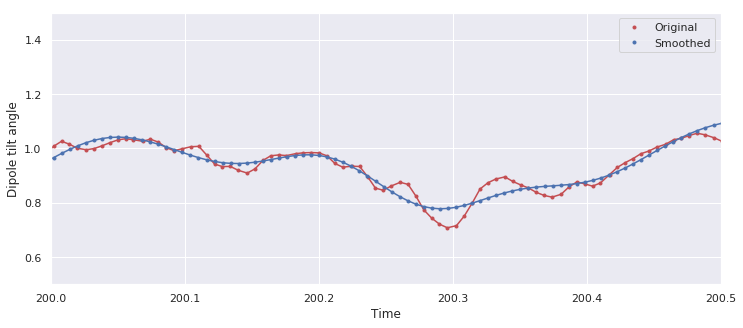

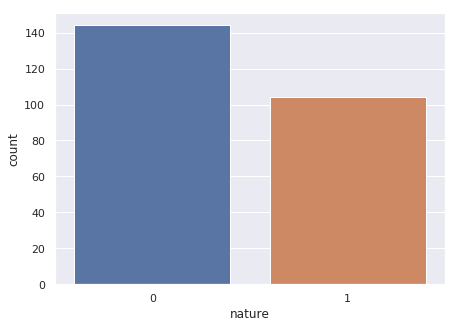

In [14]:
from sklearn.model_selection import train_test_split

# padding size (in no. of points) of the analysis window around the equator crossings
pad_size = 1000
std_thres = 0.3 # North hemi has about 0 to 1 normalized latitude range
lat_thres = 0.1 # latitude belt around equator cnsidered as 'equator'
smooth = True

increase_res, factor = True, 2
if increase_res==True:
    pad_size = factor*pad_size 
    

df_main = df

# get the data
if smooth==True: 
    df_main = smooth_data(df, low_pass_strength=1) # will produce a plot as well
    print('Data has been smoothed.')
    
# increase time series resolution using interpolation
if increase_res == True:
    df_main = increase_time_res(df_main, factor=factor)
    print('Time resolution has been increased by a factor of', factor)

    
# get where reversal/excursions happened
df_EquCross = get_EqCros(df_main, pad_size=pad_size, std_thres=std_thres, lat_thres=lat_thres)

# plot number of reversals/excursions
fig, ax = plt.subplots(figsize=(7,5))
sns.countplot(df_EquCross['nature'])

# prepare data for LSTM
X, y = cook_data(df_main, df_EquCross, pad_size=pad_size)

# Train test spilling
X_TRAIN, X_TEST, y_TRAIN, y_TEST = train_test_split(X, y, test_size=0.2, shuffle=True)

print('X train={}, Y train={}.'.format(X_TRAIN.shape, y_TRAIN.shape))
print('X test={}, Y test={}'.format(X_TEST.shape, y_TEST.shape))

# Look at some of the extracted events

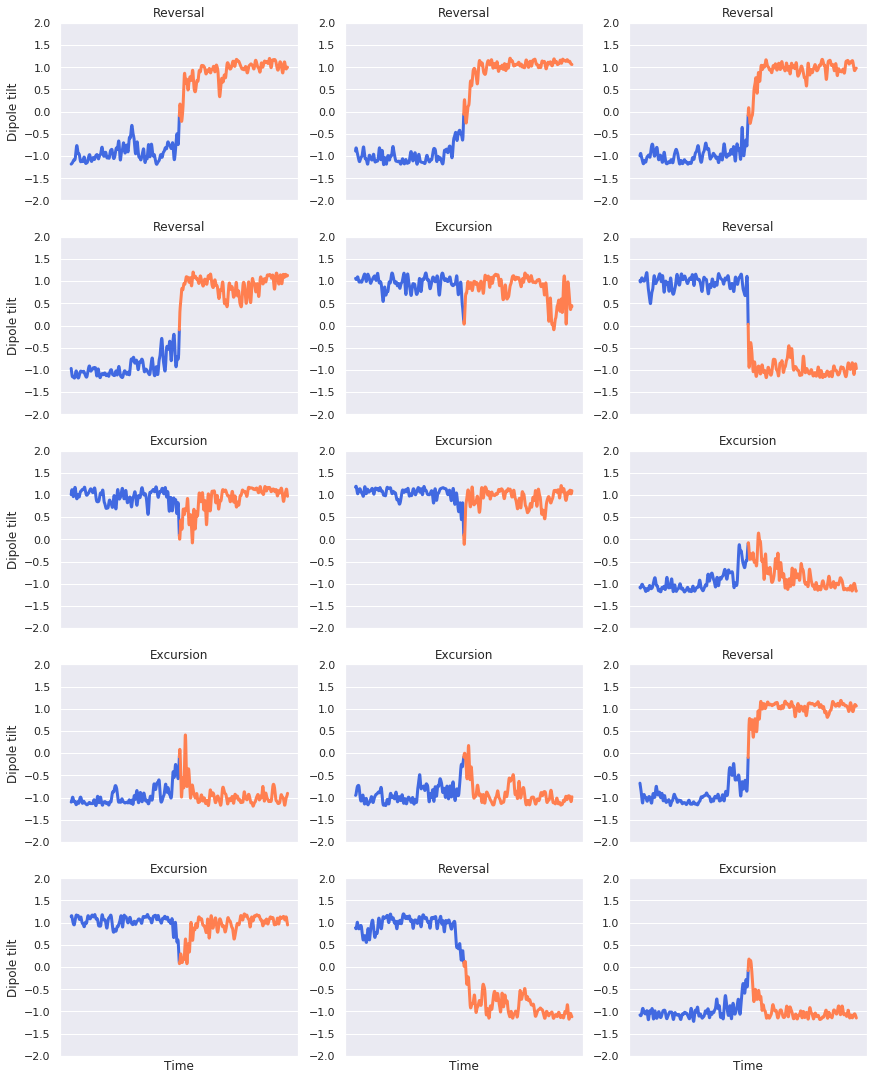

In [9]:
fig_rows=5
fig_cols=3
plot_window_size=pad_size

fig, ax = plt.subplots(fig_rows, fig_cols, figsize=(12,15))
fig.tight_layout()

for i in range(fig_rows):
    for j in range(fig_cols):
        rand_ind = np.random.randint(0,df_EquCross.shape[0])
        LeftInds = [df_EquCross.index[rand_ind]-k for k in range(plot_window_size)]
        ax[i,j].plot( df_main.iloc[LeftInds]['dipole_tilt'], '-', color='royalblue', lw=3)
        #ax[i,j].plot( df_main.iloc[LeftInds]['dip_l11'], '-', color='k', lw=1, alpha=0.3)

        RightInds = [df_EquCross.index[rand_ind]+k for k in range(plot_window_size)]
        ax[i,j].plot( df_main.iloc[RightInds]['dipole_tilt'], '-', color='coral', lw=3)
        #ax[i,j].plot( df_main.iloc[RightInds]['dip_l11'], '-', color='k', lw=1, alpha=0.3)
        
        ax[i,j].set_ylim([-2,2])

        if df_EquCross.at[df_EquCross.index[rand_ind], 'nature']==0:
            ax[i,j].set_title('Excursion')
        else:
            ax[i,j].set_title('Reversal')
        #ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].axes.get_xaxis().set_ticks([])
        if j==0:
            ax[i,j].set_ylabel('Dipole tilt')
        if i==fig_rows-1:
            ax[i,j].set_xlabel('Time')
            
plt.show()
#plt.ylabel('Dipole tilt angle')

# some diagnostic plotting functions

In [15]:
# interactively plot dipole tilts of several randomly-chosen reversals and recursions
if False:
    from IPython import display
    import time

    fig, ax = plt.subplots(figsize=(12,5))
    num_points=10
    plot_window_size=pad_size
    for i in np.random.randint(0,df_EquCross.shape[0], num_points):
        LeftInds = [df_EquCross.index[i]-j for j in range(plot_window_size)]
        plt.plot( df_main.iloc[LeftInds]['dipole_tilt'], 'b-')

        RightInds = [df_EquCross.index[i]+j for j in range(plot_window_size)]
        plt.plot( df_main.iloc[RightInds]['dipole_tilt'], 'r-')

        plt.ylim([-90,90])
        if df_EquCross.at[df_EquCross.index[i], 'nature']==0:
            plt.title('Excursion')
        else:
            plt.title('Reversal')
        plt.xlabel('Index')
        plt.ylabel('Dipole tilt angle')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(1.0)
        plt.clf()

# interactively plot LSTM input data for investigation
if False:
    from IPython import display
    import time

    fig, ax = plt.subplots(figsize=(12,5))
    num_points=10
    for i in np.random.randint(0, X_train.shape[0], num_points):#np.random.randint(0, X_test.shape[0], num_points):
        plt.plot(X_train[i,0])# dipole tilt
        #plt.plot(X_train[i,1])# l11 dipolarity
        plt.ylim([-90,90])
        plt.xlabel('Index')
        plt.ylabel('Dipole tilt angle')
        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(1.0)
        plt.clf()

# Apply machine learning to the extracted data

Here we use one LSTM (Long short term memory) neural network layer.

Also, we only consider the dipole tilt time series, i.e. only one feature.

Input training data shape: (395, 2000, 1)
Test data shape: (99, 2000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 100)               40800     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________
None
Train on 395 samples, validate on 99 samples
Epoch 1/120
395/395 [==============================] - 7s 19ms/step - loss: 0.6909 - acc: 0.5013 - val_loss: 0.6853 - val_acc: 0.5960
Epoch 2/120
395/395 [==============================] - 6s 14ms/step - loss: 0.6835 - acc: 0.5772 - val_loss: 0.6738 - val_acc: 0.6263
Epoch 3/120
395/395 [==============================] - 6s 14ms/step - loss: 0.6737 - acc: 0.5873 - val_loss: 0.6707 - val_acc: 0.5253
Epoch 4/1

395/395 [==============================] - 5s 13ms/step - loss: 0.6620 - acc: 0.5671 - val_loss: 0.6506 - val_acc: 0.6465
Epoch 57/120
395/395 [==============================] - 5s 13ms/step - loss: 0.6636 - acc: 0.5949 - val_loss: 0.6531 - val_acc: 0.6061
Epoch 58/120
395/395 [==============================] - 5s 13ms/step - loss: 0.6530 - acc: 0.5899 - val_loss: 0.6262 - val_acc: 0.6869
Epoch 59/120
395/395 [==============================] - 5s 13ms/step - loss: 0.6506 - acc: 0.5772 - val_loss: 0.6488 - val_acc: 0.6061
Epoch 60/120
395/395 [==============================] - 5s 13ms/step - loss: 0.6477 - acc: 0.6101 - val_loss: 0.6336 - val_acc: 0.6263
Epoch 61/120
395/395 [==============================] - 5s 13ms/step - loss: 0.6417 - acc: 0.5975 - val_loss: 0.6335 - val_acc: 0.5960
Epoch 62/120
395/395 [==============================] - 5s 13ms/step - loss: 0.6455 - acc: 0.6253 - val_loss: 0.6208 - val_acc: 0.6162
Epoch 63/120
395/395 [==============================] - 5s 12ms/step

395/395 [==============================] - 6s 15ms/step - loss: 0.6230 - acc: 0.6228 - val_loss: 0.5801 - val_acc: 0.5960
Epoch 117/120
395/395 [==============================] - 5s 13ms/step - loss: 0.6021 - acc: 0.6405 - val_loss: 0.5567 - val_acc: 0.7071
Epoch 118/120
395/395 [==============================] - 6s 15ms/step - loss: 0.6076 - acc: 0.6051 - val_loss: 0.5569 - val_acc: 0.7172
Epoch 119/120
395/395 [==============================] - 5s 13ms/step - loss: 0.5906 - acc: 0.6456 - val_loss: 0.5686 - val_acc: 0.6667
Epoch 120/120
395/395 [==============================] - 5s 13ms/step - loss: 0.5868 - acc: 0.6633 - val_loss: 0.5880 - val_acc: 0.5960


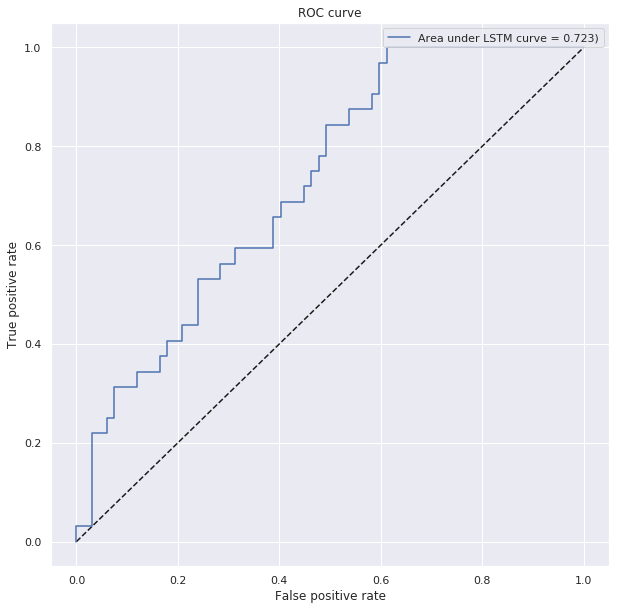

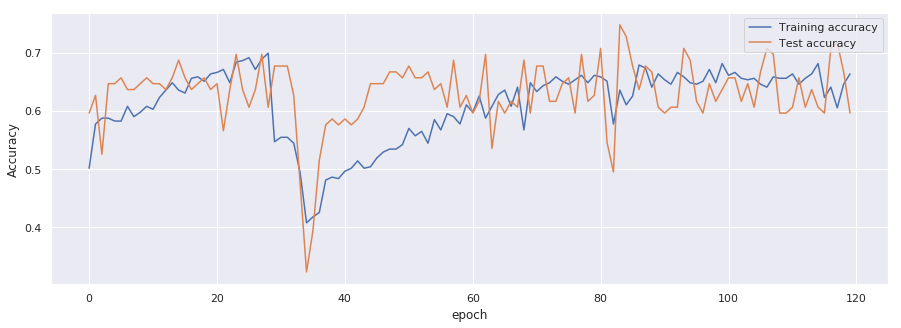

In [24]:
# create the model, use only the dipole tilt info

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# X train -> (instance, features, data)

X_train = X_TRAIN[:,0,:].reshape((X_TRAIN.shape[0], X_TRAIN.shape[2], 1))
print('Input training data shape:', X_train.shape)
X_test = X_TEST[:,0,:].reshape((X_TEST.shape[0], X_TEST.shape[2], 1))
print('Test data shape:', X_test.shape)

y_train, y_test = y_TRAIN, y_TEST

epochs, batch_size = 120, 64

model = Sequential()

#LSTM layer(s)
model.add(LSTM(100, input_shape=(pad_size, 1)))

#output layer
model.add(Dense(1, activation='sigmoid')) # relu, softmax not good

print(model.summary())

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
history=model.fit(X_train, y_train, 
                  epochs=epochs, 
                  batch_size=batch_size,
                  validation_data=(X_test, y_test)
                 )

# get ROC curve for the model
from sklearn.metrics import roc_curve, auc
# predict labels of test set
y_test_pred = model.predict(X_test).ravel()
fpr_L, tpr_L, thresholds_L = roc_curve(y_test, y_test_pred)
auc_L = auc(fpr_L, tpr_L)

fig, ax = plt.subplots(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_L, tpr_L, label='Area under LSTM curve = {:.3f})'.format(auc_L))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# accuracy history
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(history.history['acc'], label='Training accuracy')
plt.plot(history.history['val_acc'], label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')


plt.show()

# Here we use two LSTM layers and one feature

Input training data shape: (395, 2000, 1)
Test data shape: (99, 2000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 2000, 100)         40800     
_________________________________________________________________
dropout_9 (Dropout)          (None, 2000, 100)         0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 20)                9680      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 50,501
Trainable params: 50,501
Non-trainable params: 0
_________________________________________________________________
None
Train on 395 samples, validate on 99 samples
Epoch 1/100
395/395 [==============================] - 13s 33ms/step - loss: 0.6918 - acc: 0.5165 - val_loss: 0.6902 - val_acc: 0.4949
Epoch 2/100


395/395 [==============================] - 9s 24ms/step - loss: 0.4161 - acc: 0.7570 - val_loss: 0.4155 - val_acc: 0.7778
Epoch 55/100
395/395 [==============================] - 9s 24ms/step - loss: 0.4119 - acc: 0.7646 - val_loss: 0.4033 - val_acc: 0.8081
Epoch 56/100
395/395 [==============================] - 9s 24ms/step - loss: 0.4243 - acc: 0.7747 - val_loss: 0.4133 - val_acc: 0.7576
Epoch 57/100
395/395 [==============================] - 9s 24ms/step - loss: 0.4135 - acc: 0.7722 - val_loss: 0.3974 - val_acc: 0.7677
Epoch 58/100
395/395 [==============================] - 9s 24ms/step - loss: 0.4115 - acc: 0.7696 - val_loss: 0.4011 - val_acc: 0.7879
Epoch 59/100
395/395 [==============================] - 9s 24ms/step - loss: 0.3976 - acc: 0.7848 - val_loss: 0.3848 - val_acc: 0.8081
Epoch 60/100
395/395 [==============================] - 10s 24ms/step - loss: 0.4253 - acc: 0.7848 - val_loss: 0.3921 - val_acc: 0.7778
Epoch 61/100
395/395 [==============================] - 9s 24ms/ste

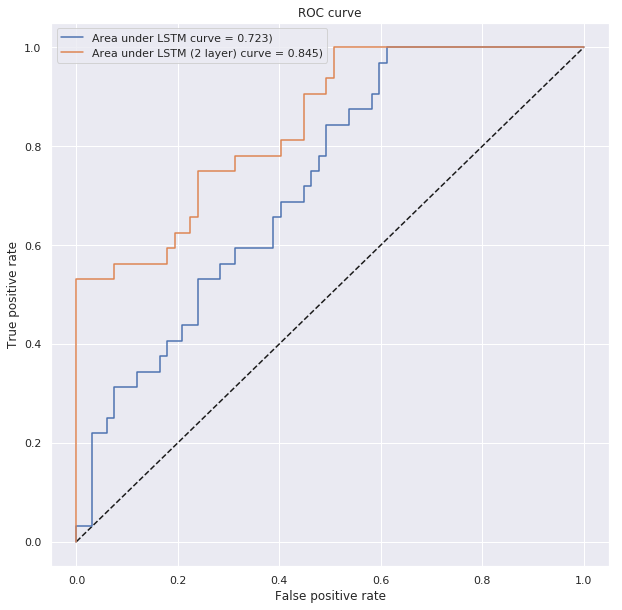

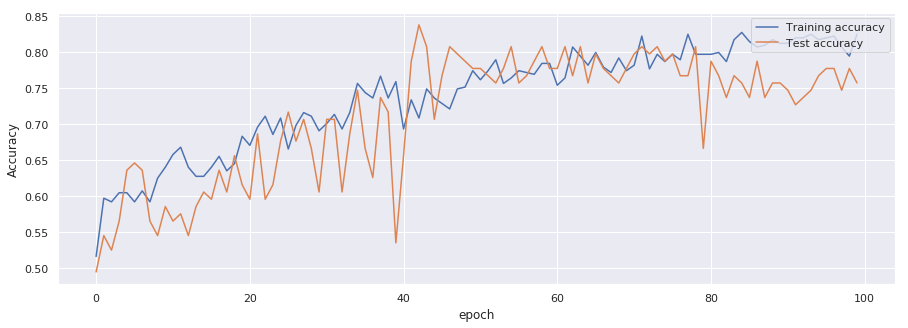

In [27]:
# X train -> (instance, features, data)

X_train = X_TRAIN[:,0,:].reshape((X_TRAIN.shape[0], X_TRAIN.shape[2], 1))
print('Input training data shape:', X_train.shape)
X_test = X_TEST[:,0,:].reshape((X_TEST.shape[0], X_TEST.shape[2], 1))
print('Test data shape:', X_test.shape)

y_train, y_test = y_TRAIN, y_TEST

epochs, batch_size = 100, 64

model2 = Sequential()

#LSTM layer(s)
model2.add(LSTM(100, input_shape=(pad_size, 1), return_sequences=True))
model2.add(Dropout(0.2)) # should help in avoiding overfitting
model2.add(LSTM(20))

#output layer
model2.add(Dense(1, activation='sigmoid')) # relu, softmax not good

print(model2.summary())

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size)
history2=model2.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_test, y_test)
                   )

# predict labels of test set
y_test_pred = model2.predict(X_test).ravel()
fpr_L2, tpr_L2, thresholds_L2 = roc_curve(y_test, y_test_pred)
auc_L2 = auc(fpr_L2, tpr_L2)

fig, ax = plt.subplots(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_L, tpr_L, label='Area under LSTM curve = {:.3f})'.format(auc_L))
plt.plot(fpr_L2, tpr_L2, label='Area under LSTM (2 layer) curve = {:.3f})'.format(auc_L2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# accuracy history
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(history2.history['acc'], label='Training accuracy')
plt.plot(history2.history['val_acc'], label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')


plt.show()

# Here we combine Convolutional Neural Networks (CNNs) with LSTMs. 

We use one feature.

One CNN layer with multiple LSTM layers.

Input training data shape: (395, 2000, 1)
Test data shape: (99, 2000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 2000, 8)           32        
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1000, 8)           0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 1000, 100)         43600     
_________________________________________________________________
dropout_11 (Dropout)         (None, 1000, 100)         0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 20)                9680      
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 21        
Total params: 53,333
Trainable params: 53,333
Non-trainable params: 0

395/395 [==============================] - 5s 12ms/step - loss: 0.4733 - acc: 0.7392 - val_loss: 0.5252 - val_acc: 0.7475
Epoch 53/100
395/395 [==============================] - 5s 13ms/step - loss: 0.4712 - acc: 0.7494 - val_loss: 0.5077 - val_acc: 0.6566
Epoch 54/100
395/395 [==============================] - 5s 12ms/step - loss: 0.4634 - acc: 0.7291 - val_loss: 0.4644 - val_acc: 0.7172
Epoch 55/100
395/395 [==============================] - 5s 13ms/step - loss: 0.4483 - acc: 0.7696 - val_loss: 0.4745 - val_acc: 0.6768
Epoch 56/100
395/395 [==============================] - 5s 12ms/step - loss: 0.4296 - acc: 0.8051 - val_loss: 0.4956 - val_acc: 0.6768
Epoch 57/100
395/395 [==============================] - 5s 12ms/step - loss: 0.4363 - acc: 0.7823 - val_loss: 0.4991 - val_acc: 0.7273
Epoch 58/100
395/395 [==============================] - 5s 12ms/step - loss: 0.4428 - acc: 0.7747 - val_loss: 0.4772 - val_acc: 0.6465
Epoch 59/100
395/395 [==============================] - 5s 13ms/step

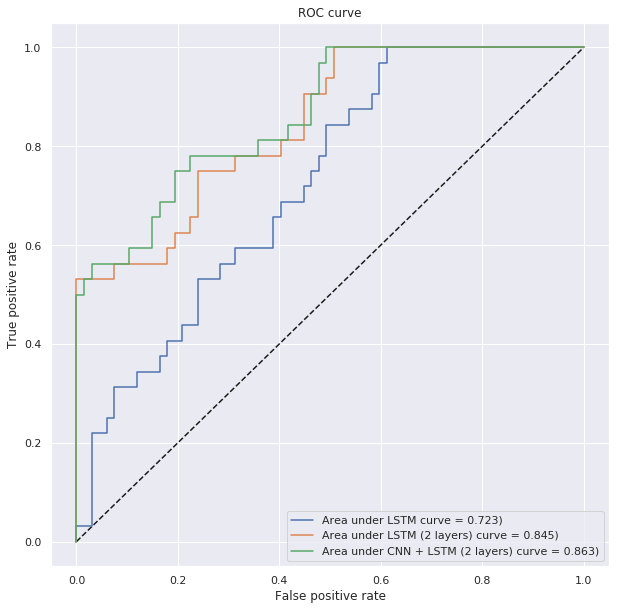

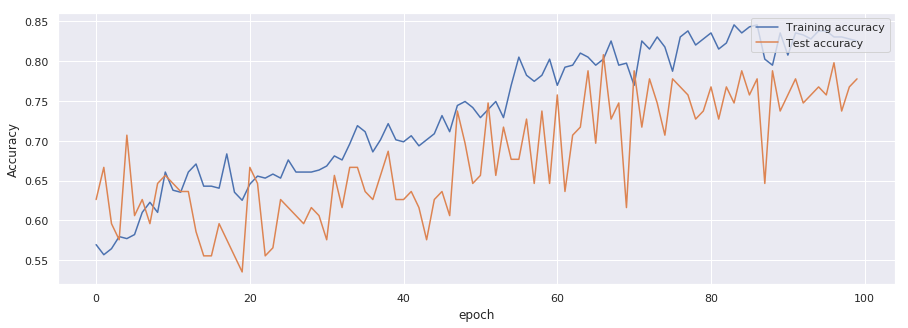

In [29]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten


X_train = X_TRAIN[:,0,:].reshape((X_TRAIN.shape[0], X_TRAIN.shape[2], 1))
print('Input training data shape:', X_train.shape)
X_test = X_TEST[:,0,:].reshape((X_TEST.shape[0], X_TEST.shape[2], 1))
print('Test data shape:', X_test.shape)

y_train, y_test = y_TRAIN, y_TEST

epochs, batch_size = 100, 64
filters = 8


model3 = Sequential()

# conv layer 1
model3.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu', 
                  input_shape=(X_train.shape[1],X_train.shape[2])))
model3.add(MaxPooling1D(pool_size=2)) #reduced data size

# LSTM layers
model3.add(LSTM(100, return_sequences=True))
model3.add(Dropout(0.2))
model3.add(LSTM(20))

#output layer
model3.add(Dense(1, activation='sigmoid'))

print(model3.summary())

model3.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']
              )


history3 = model3.fit(X_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size,
                      validation_data=(X_test, y_test)
                     )


# ------------get ROC curve for the model
y_test_pred = model3.predict(X_test).ravel()
fpr_C1L2, tpr_C1L2, thresholds_C1L2 = roc_curve(y_test, y_test_pred)
auc_C1L2 = auc(fpr_C1L2, tpr_C1L2)

fig, ax = plt.subplots(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_L, tpr_L, label='Area under LSTM curve = {:.3f})'.format(auc_L))
plt.plot(fpr_L2, tpr_L2, label='Area under LSTM (2 layers) curve = {:.3f})'.format(auc_L2))
plt.plot(fpr_C1L2, tpr_C1L2, label='Area under CNN + LSTM (2 layers) curve = {:.3f})'.format(auc_C1L2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# accuracy history
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(history3.history['acc'], label='Training accuracy')
plt.plot(history3.history['val_acc'], label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')



plt.show()

# 2 CNN layers, 2 LSTM layers, 1 feature

Input training data shape: (395, 2000, 1)
Test data shape: (99, 2000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 2000, 8)           32        
_________________________________________________________________
max_pooling1d_35 (MaxPooling (None, 1000, 8)           0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 1000, 8)           200       
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 500, 8)            0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 500, 100)          43600     
_________________________________________________________________
dropout_23 (Dropout)         (None, 500, 100)          0         
_________________________________________________________________
lst

Epoch 51/150
395/395 [==============================] - 2s 6ms/step - loss: 0.3512 - acc: 0.8000 - val_loss: 0.3634 - val_acc: 0.8283
Epoch 52/150
395/395 [==============================] - 3s 7ms/step - loss: 0.3427 - acc: 0.8076 - val_loss: 0.3855 - val_acc: 0.7273
Epoch 53/150
395/395 [==============================] - 3s 7ms/step - loss: 0.3377 - acc: 0.8127 - val_loss: 0.3746 - val_acc: 0.8182
Epoch 54/150
395/395 [==============================] - 3s 9ms/step - loss: 0.3319 - acc: 0.8329 - val_loss: 0.3720 - val_acc: 0.8283
Epoch 55/150
395/395 [==============================] - 3s 7ms/step - loss: 0.3390 - acc: 0.8354 - val_loss: 0.3919 - val_acc: 0.7374
Epoch 56/150
395/395 [==============================] - 3s 6ms/step - loss: 0.3368 - acc: 0.8380 - val_loss: 0.3772 - val_acc: 0.7879
Epoch 57/150
395/395 [==============================] - 3s 7ms/step - loss: 0.3388 - acc: 0.8000 - val_loss: 0.3779 - val_acc: 0.7879
Epoch 58/150
395/395 [==============================] - 3s 7ms

395/395 [==============================] - 3s 7ms/step - loss: 0.2767 - acc: 0.8608 - val_loss: 0.3948 - val_acc: 0.7677
Epoch 113/150
395/395 [==============================] - 3s 6ms/step - loss: 0.2924 - acc: 0.8481 - val_loss: 0.3942 - val_acc: 0.7879
Epoch 114/150
395/395 [==============================] - 2s 6ms/step - loss: 0.2865 - acc: 0.8430 - val_loss: 0.4002 - val_acc: 0.7475
Epoch 115/150
395/395 [==============================] - 2s 6ms/step - loss: 0.2734 - acc: 0.8582 - val_loss: 0.3656 - val_acc: 0.7879
Epoch 116/150
395/395 [==============================] - 2s 6ms/step - loss: 0.2780 - acc: 0.8557 - val_loss: 0.3795 - val_acc: 0.7677
Epoch 117/150
395/395 [==============================] - 2s 6ms/step - loss: 0.2910 - acc: 0.8456 - val_loss: 0.3744 - val_acc: 0.7778
Epoch 118/150
395/395 [==============================] - 2s 6ms/step - loss: 0.2992 - acc: 0.8456 - val_loss: 0.4040 - val_acc: 0.7677
Epoch 119/150
395/395 [==============================] - 2s 6ms/step 

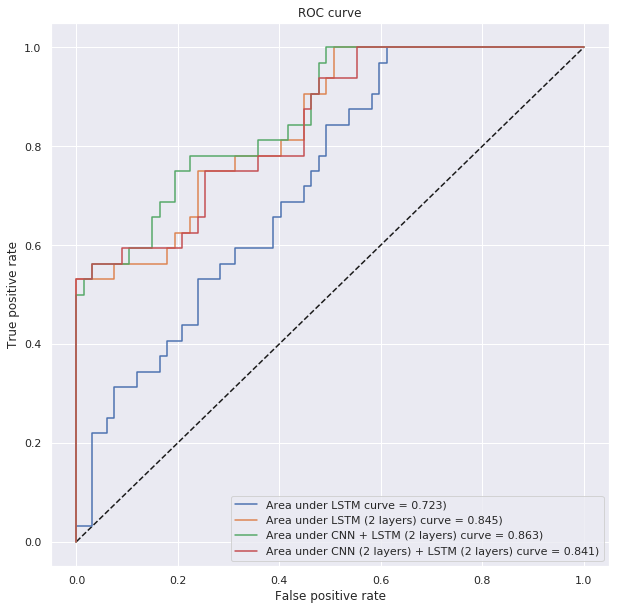

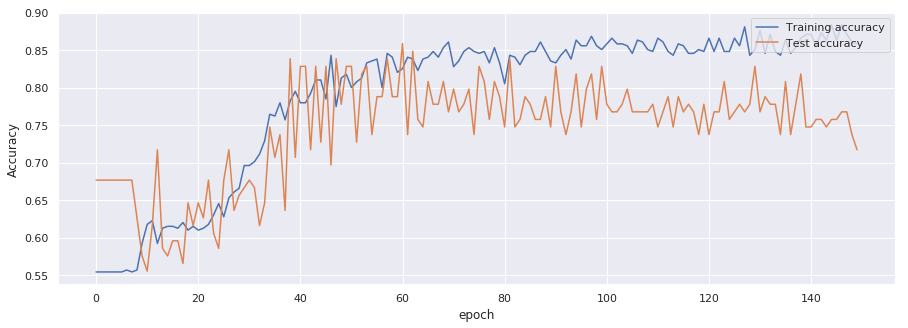

In [41]:

X_train = X_TRAIN[:,0,:].reshape((X_TRAIN.shape[0], X_TRAIN.shape[2], 1))
print('Input training data shape:', X_train.shape)
X_test = X_TEST[:,0,:].reshape((X_TEST.shape[0], X_TEST.shape[2], 1))
print('Test data shape:', X_test.shape)

y_train, y_test = y_TRAIN, y_TEST

epochs, batch_size = 150, 64
filters = 8


model4 = Sequential()

# conv layer 1
model4.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu', 
                  input_shape=(X_train.shape[1],X_train.shape[2])))
model4.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 2
model4.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu'))
model4.add(MaxPooling1D(pool_size=2)) #reduced data size

# LSTM layers
model4.add(LSTM(100, return_sequences=True))
model4.add(Dropout(0.2))
model4.add(LSTM(20))

#output layer
model4.add(Dense(1, activation='sigmoid'))

print(model4.summary())

model4.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']
              )


history4 = model4.fit(X_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size,
                      validation_data=(X_test, y_test)
                     )


# ------------get ROC curve for the model
y_test_pred = model4.predict(X_test).ravel()
fpr_C2L2, tpr_C2L2, thresholds_C2L2 = roc_curve(y_test, y_test_pred)
auc_C2L2 = auc(fpr_C2L2, tpr_C2L2)

fig, ax = plt.subplots(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_L, tpr_L, label='Area under LSTM curve = {:.3f})'.format(auc_L))
plt.plot(fpr_L2, tpr_L2, label='Area under LSTM (2 layers) curve = {:.3f})'.format(auc_L2))
plt.plot(fpr_C1L2, tpr_C1L2, label='Area under CNN + LSTM (2 layers) curve = {:.3f})'.format(auc_C1L2))
plt.plot(fpr_C2L2, tpr_C2L2, label='Area under CNN (2 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C2L2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# accuracy history
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(history4.history['acc'], label='Training accuracy')
plt.plot(history4.history['val_acc'], label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')



plt.show()

# 3 CNN layers, 2 LSTM layers, 1 feature

Input training data shape: (395, 2000, 1)
Test data shape: (99, 2000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_37 (Conv1D)           (None, 2000, 8)           32        
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 1000, 8)           0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 1000, 8)           200       
_________________________________________________________________
max_pooling1d_38 (MaxPooling (None, 500, 8)            0         
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 500, 8)            200       
_________________________________________________________________
max_pooling1d_39 (MaxPooling (None, 250, 8)            0         
_________________________________________________________________
lst

Epoch 49/200
395/395 [==============================] - 2s 4ms/step - loss: 0.3538 - acc: 0.8101 - val_loss: 0.3683 - val_acc: 0.8081
Epoch 50/200
395/395 [==============================] - 2s 4ms/step - loss: 0.3458 - acc: 0.8203 - val_loss: 0.3952 - val_acc: 0.7576
Epoch 51/200
395/395 [==============================] - 2s 4ms/step - loss: 0.3452 - acc: 0.8278 - val_loss: 0.3829 - val_acc: 0.8182
Epoch 52/200
395/395 [==============================] - 1s 4ms/step - loss: 0.3476 - acc: 0.8430 - val_loss: 0.4432 - val_acc: 0.6970
Epoch 53/200
395/395 [==============================] - 1s 4ms/step - loss: 0.3575 - acc: 0.8101 - val_loss: 0.3874 - val_acc: 0.7778
Epoch 54/200
395/395 [==============================] - 1s 3ms/step - loss: 0.3443 - acc: 0.8051 - val_loss: 0.3723 - val_acc: 0.7980
Epoch 55/200
395/395 [==============================] - 1s 3ms/step - loss: 0.3344 - acc: 0.8405 - val_loss: 0.3665 - val_acc: 0.7980
Epoch 56/200
395/395 [==============================] - 1s 3ms

395/395 [==============================] - 1s 3ms/step - loss: 0.2743 - acc: 0.8633 - val_loss: 0.3895 - val_acc: 0.7677
Epoch 111/200
395/395 [==============================] - 1s 3ms/step - loss: 0.2853 - acc: 0.8658 - val_loss: 0.4214 - val_acc: 0.7475
Epoch 112/200
395/395 [==============================] - 1s 3ms/step - loss: 0.2798 - acc: 0.8557 - val_loss: 0.4110 - val_acc: 0.7475
Epoch 113/200
395/395 [==============================] - 1s 3ms/step - loss: 0.3098 - acc: 0.8203 - val_loss: 0.4163 - val_acc: 0.7374
Epoch 114/200
395/395 [==============================] - 1s 3ms/step - loss: 0.2789 - acc: 0.8557 - val_loss: 0.3777 - val_acc: 0.7778
Epoch 115/200
395/395 [==============================] - 1s 3ms/step - loss: 0.2922 - acc: 0.8532 - val_loss: 0.3706 - val_acc: 0.7576
Epoch 116/200
395/395 [==============================] - 1s 3ms/step - loss: 0.2698 - acc: 0.8709 - val_loss: 0.3963 - val_acc: 0.7879
Epoch 117/200
395/395 [==============================] - 1s 3ms/step 

Epoch 171/200
395/395 [==============================] - 1s 3ms/step - loss: 0.2122 - acc: 0.8937 - val_loss: 0.4217 - val_acc: 0.7778
Epoch 172/200
395/395 [==============================] - 1s 3ms/step - loss: 0.2098 - acc: 0.8962 - val_loss: 0.4406 - val_acc: 0.7879
Epoch 173/200
395/395 [==============================] - 1s 3ms/step - loss: 0.1940 - acc: 0.9038 - val_loss: 0.4590 - val_acc: 0.7475
Epoch 174/200
395/395 [==============================] - 1s 3ms/step - loss: 0.2129 - acc: 0.8861 - val_loss: 0.4555 - val_acc: 0.7172
Epoch 175/200
395/395 [==============================] - 1s 3ms/step - loss: 0.2144 - acc: 0.8937 - val_loss: 0.5146 - val_acc: 0.7980
Epoch 176/200
395/395 [==============================] - 1s 3ms/step - loss: 0.2150 - acc: 0.8987 - val_loss: 0.4553 - val_acc: 0.8081
Epoch 177/200
395/395 [==============================] - 1s 3ms/step - loss: 0.2077 - acc: 0.9038 - val_loss: 0.4149 - val_acc: 0.7778
Epoch 178/200
395/395 [==============================] 

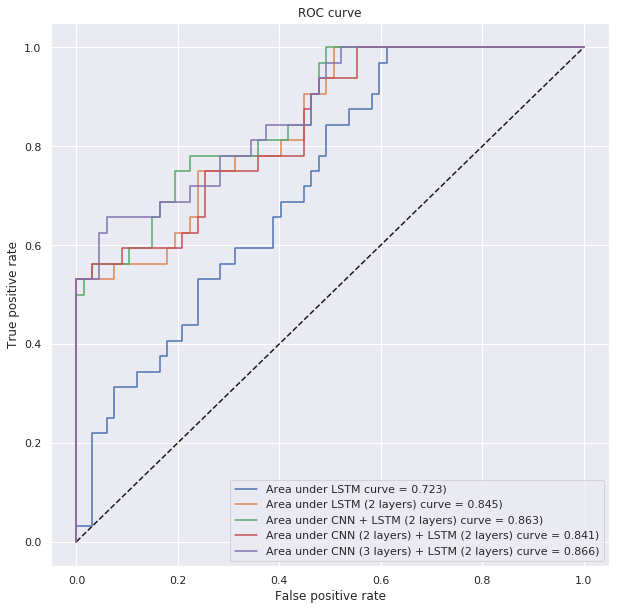

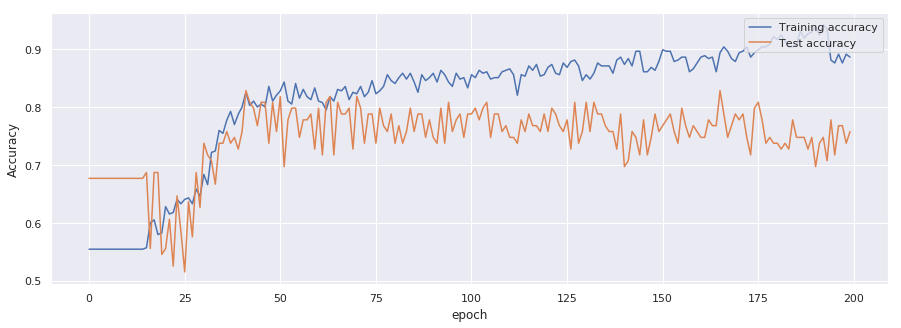

In [42]:

X_train = X_TRAIN[:,0,:].reshape((X_TRAIN.shape[0], X_TRAIN.shape[2], 1))
print('Input training data shape:', X_train.shape)
X_test = X_TEST[:,0,:].reshape((X_TEST.shape[0], X_TEST.shape[2], 1))
print('Test data shape:', X_test.shape)

y_train, y_test = y_TRAIN, y_TEST

epochs, batch_size = 200, 64
filters = 8


model5 = Sequential()

# conv layer 1
model5.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu', 
                  input_shape=(X_train.shape[1],X_train.shape[2])))
model5.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 2
model5.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu'))
model5.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 3
model5.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu'))
model5.add(MaxPooling1D(pool_size=2)) #reduced data size

# LSTM layers
model5.add(LSTM(100, return_sequences=True))
model5.add(Dropout(0.2))
model5.add(LSTM(20))

#output layer
model5.add(Dense(1, activation='sigmoid'))

print(model5.summary())

model5.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']
              )


history5 = model5.fit(X_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size,
                      validation_data=(X_test, y_test)
                     )


# ------------get ROC curve for the model
y_test_pred = model5.predict(X_test).ravel()
fpr_C3L2, tpr_C3L2, thresholds_C3L2 = roc_curve(y_test, y_test_pred)
auc_C3L2 = auc(fpr_C3L2, tpr_C3L2)

fig, ax = plt.subplots(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_L, tpr_L, label='Area under LSTM curve = {:.3f})'.format(auc_L))
plt.plot(fpr_L2, tpr_L2, label='Area under LSTM (2 layers) curve = {:.3f})'.format(auc_L2))
plt.plot(fpr_C1L2, tpr_C1L2, label='Area under CNN + LSTM (2 layers) curve = {:.3f})'.format(auc_C1L2))
plt.plot(fpr_C2L2, tpr_C2L2, label='Area under CNN (2 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C2L2))
plt.plot(fpr_C3L2, tpr_C3L2, label='Area under CNN (3 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C3L2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# accuracy history
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(history5.history['acc'], label='Training accuracy')
plt.plot(history5.history['val_acc'], label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')



plt.show()

# 4 CNN layers, 2 LSTM layers, 1 feature

Input training data shape: (395, 2000, 1)
Test data shape: (99, 2000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 2000, 8)           32        
_________________________________________________________________
max_pooling1d_40 (MaxPooling (None, 1000, 8)           0         
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 1000, 8)           200       
_________________________________________________________________
max_pooling1d_41 (MaxPooling (None, 500, 8)            0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 500, 8)            200       
_________________________________________________________________
max_pooling1d_42 (MaxPooling (None, 250, 8)            0         
_________________________________________________________________
con

Epoch 47/250
395/395 [==============================] - 1s 2ms/step - loss: 0.4093 - acc: 0.8076 - val_loss: 0.3786 - val_acc: 0.8182
Epoch 48/250
395/395 [==============================] - 1s 2ms/step - loss: 0.4079 - acc: 0.7772 - val_loss: 0.3861 - val_acc: 0.8081
Epoch 49/250
395/395 [==============================] - 1s 2ms/step - loss: 0.3979 - acc: 0.7924 - val_loss: 0.3670 - val_acc: 0.8384
Epoch 50/250
395/395 [==============================] - 1s 2ms/step - loss: 0.3956 - acc: 0.7873 - val_loss: 0.4415 - val_acc: 0.7172
Epoch 51/250
395/395 [==============================] - 1s 2ms/step - loss: 0.4044 - acc: 0.7848 - val_loss: 0.3668 - val_acc: 0.8182
Epoch 52/250
395/395 [==============================] - 1s 2ms/step - loss: 0.3781 - acc: 0.7873 - val_loss: 0.3966 - val_acc: 0.7879
Epoch 53/250
395/395 [==============================] - 1s 2ms/step - loss: 0.3624 - acc: 0.8127 - val_loss: 0.3558 - val_acc: 0.8283
Epoch 54/250
395/395 [==============================] - 1s 2ms

395/395 [==============================] - 1s 2ms/step - loss: 0.2994 - acc: 0.8456 - val_loss: 0.3853 - val_acc: 0.7778
Epoch 109/250
395/395 [==============================] - 1s 2ms/step - loss: 0.2983 - acc: 0.8481 - val_loss: 0.3770 - val_acc: 0.8081
Epoch 110/250
395/395 [==============================] - 1s 2ms/step - loss: 0.3055 - acc: 0.8456 - val_loss: 0.4070 - val_acc: 0.7576
Epoch 111/250
395/395 [==============================] - 1s 3ms/step - loss: 0.3027 - acc: 0.8380 - val_loss: 0.3878 - val_acc: 0.7677
Epoch 112/250
395/395 [==============================] - 1s 2ms/step - loss: 0.3104 - acc: 0.8278 - val_loss: 0.4024 - val_acc: 0.7677
Epoch 113/250
395/395 [==============================] - 1s 2ms/step - loss: 0.3022 - acc: 0.8532 - val_loss: 0.3783 - val_acc: 0.8384
Epoch 114/250
395/395 [==============================] - 1s 2ms/step - loss: 0.3127 - acc: 0.8380 - val_loss: 0.3789 - val_acc: 0.7879
Epoch 115/250
395/395 [==============================] - 1s 2ms/step 

Epoch 169/250
395/395 [==============================] - 1s 2ms/step - loss: 0.2755 - acc: 0.8658 - val_loss: 0.4187 - val_acc: 0.8081
Epoch 170/250
395/395 [==============================] - 1s 2ms/step - loss: 0.3027 - acc: 0.8506 - val_loss: 0.3811 - val_acc: 0.8182
Epoch 171/250
395/395 [==============================] - 1s 2ms/step - loss: 0.2927 - acc: 0.8481 - val_loss: 0.3807 - val_acc: 0.7778
Epoch 172/250
395/395 [==============================] - 1s 2ms/step - loss: 0.2977 - acc: 0.8481 - val_loss: 0.3751 - val_acc: 0.8081
Epoch 173/250
395/395 [==============================] - 1s 2ms/step - loss: 0.2862 - acc: 0.8582 - val_loss: 0.4148 - val_acc: 0.7273
Epoch 174/250
395/395 [==============================] - 1s 2ms/step - loss: 0.2874 - acc: 0.8532 - val_loss: 0.3644 - val_acc: 0.7980
Epoch 175/250
395/395 [==============================] - 1s 2ms/step - loss: 0.2830 - acc: 0.8557 - val_loss: 0.3894 - val_acc: 0.7879
Epoch 176/250
395/395 [==============================] 

395/395 [==============================] - 1s 2ms/step - loss: 0.2503 - acc: 0.8532 - val_loss: 0.4127 - val_acc: 0.7677
Epoch 230/250
395/395 [==============================] - 1s 2ms/step - loss: 0.2438 - acc: 0.8759 - val_loss: 0.3837 - val_acc: 0.8182
Epoch 231/250
395/395 [==============================] - 1s 2ms/step - loss: 0.2428 - acc: 0.9013 - val_loss: 0.3942 - val_acc: 0.7980
Epoch 232/250
395/395 [==============================] - 1s 2ms/step - loss: 0.2412 - acc: 0.8835 - val_loss: 0.4076 - val_acc: 0.7677
Epoch 233/250
395/395 [==============================] - 1s 2ms/step - loss: 0.2406 - acc: 0.8684 - val_loss: 0.3954 - val_acc: 0.8182
Epoch 234/250
395/395 [==============================] - 1s 2ms/step - loss: 0.2413 - acc: 0.8709 - val_loss: 0.3738 - val_acc: 0.7980
Epoch 235/250
395/395 [==============================] - 1s 2ms/step - loss: 0.2513 - acc: 0.8684 - val_loss: 0.3729 - val_acc: 0.8182
Epoch 236/250
395/395 [==============================] - 1s 2ms/step 

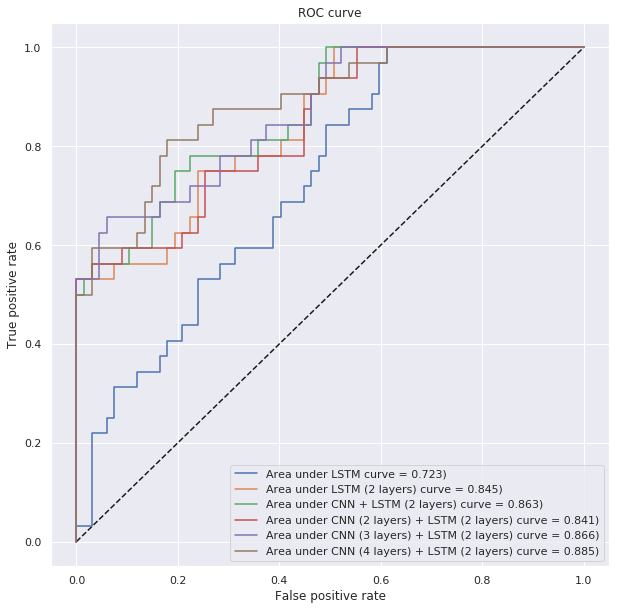

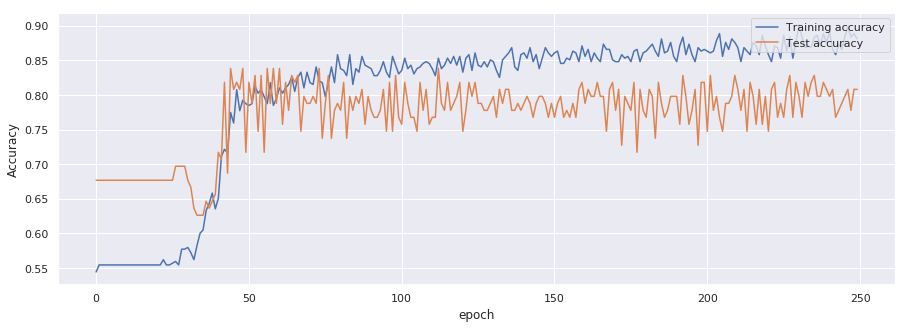

In [43]:

X_train = X_TRAIN[:,0,:].reshape((X_TRAIN.shape[0], X_TRAIN.shape[2], 1))
print('Input training data shape:', X_train.shape)
X_test = X_TEST[:,0,:].reshape((X_TEST.shape[0], X_TEST.shape[2], 1))
print('Test data shape:', X_test.shape)

y_train, y_test = y_TRAIN, y_TEST

epochs, batch_size = 250, 64
filters = 8


model6 = Sequential()

# conv layer 1
model6.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu', 
                  input_shape=(X_train.shape[1],X_train.shape[2])))
model6.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 2
model6.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu'))
model6.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 3
model6.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu'))
model6.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 4
model6.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu'))
model6.add(MaxPooling1D(pool_size=2)) #reduced data size

# LSTM layers
model6.add(LSTM(100, return_sequences=True))
model6.add(Dropout(0.2))
model6.add(LSTM(20))

#output layer
model6.add(Dense(1, activation='sigmoid'))

print(model6.summary())

model6.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']
              )


history6 = model6.fit(X_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size,
                      validation_data=(X_test, y_test)
                     )


# ------------get ROC curve for the model
y_test_pred = model6.predict(X_test).ravel()
fpr_C4L2, tpr_C4L2, thresholds_C4L2 = roc_curve(y_test, y_test_pred)
auc_C4L2 = auc(fpr_C4L2, tpr_C4L2)

fig, ax = plt.subplots(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_L, tpr_L, label='Area under LSTM curve = {:.3f})'.format(auc_L))
plt.plot(fpr_L2, tpr_L2, label='Area under LSTM (2 layers) curve = {:.3f})'.format(auc_L2))
plt.plot(fpr_C1L2, tpr_C1L2, label='Area under CNN + LSTM (2 layers) curve = {:.3f})'.format(auc_C1L2))
plt.plot(fpr_C2L2, tpr_C2L2, label='Area under CNN (2 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C2L2))
plt.plot(fpr_C3L2, tpr_C3L2, label='Area under CNN (3 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C3L2))
plt.plot(fpr_C4L2, tpr_C4L2, label='Area under CNN (4 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C4L2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# accuracy history
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(history6.history['acc'], label='Training accuracy')
plt.plot(history6.history['val_acc'], label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')



plt.show()

# 5 CNN layers, 2 LSTM layers, 1 feature

Input training data shape: (395, 2000, 1)
Test data shape: (99, 2000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_44 (Conv1D)           (None, 2000, 8)           32        
_________________________________________________________________
max_pooling1d_44 (MaxPooling (None, 1000, 8)           0         
_________________________________________________________________
conv1d_45 (Conv1D)           (None, 1000, 8)           200       
_________________________________________________________________
max_pooling1d_45 (MaxPooling (None, 500, 8)            0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 500, 8)            200       
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 250, 8)            0         
_________________________________________________________________
con

Epoch 45/200
395/395 [==============================] - 0s 1ms/step - loss: 0.6026 - acc: 0.6228 - val_loss: 0.5914 - val_acc: 0.5354
Epoch 46/200
395/395 [==============================] - 0s 1ms/step - loss: 0.5991 - acc: 0.6456 - val_loss: 0.5842 - val_acc: 0.6869
Epoch 47/200
395/395 [==============================] - 0s 1ms/step - loss: 0.5993 - acc: 0.6405 - val_loss: 0.5833 - val_acc: 0.6869
Epoch 48/200
395/395 [==============================] - 0s 1ms/step - loss: 0.5970 - acc: 0.6785 - val_loss: 0.5731 - val_acc: 0.6667
Epoch 49/200
395/395 [==============================] - 0s 1ms/step - loss: 0.5780 - acc: 0.6734 - val_loss: 0.5678 - val_acc: 0.5758
Epoch 50/200
395/395 [==============================] - 0s 1ms/step - loss: 0.5759 - acc: 0.6608 - val_loss: 0.5508 - val_acc: 0.5758
Epoch 51/200
395/395 [==============================] - 0s 1ms/step - loss: 0.5545 - acc: 0.6759 - val_loss: 0.5343 - val_acc: 0.5657
Epoch 52/200
395/395 [==============================] - 0s 1ms

395/395 [==============================] - 0s 1ms/step - loss: 0.2906 - acc: 0.8456 - val_loss: 0.4266 - val_acc: 0.7778
Epoch 107/200
395/395 [==============================] - 0s 1ms/step - loss: 0.2831 - acc: 0.8658 - val_loss: 0.4722 - val_acc: 0.7576
Epoch 108/200
395/395 [==============================] - 0s 1ms/step - loss: 0.2803 - acc: 0.8532 - val_loss: 0.4560 - val_acc: 0.7677
Epoch 109/200
395/395 [==============================] - 0s 1ms/step - loss: 0.2741 - acc: 0.8684 - val_loss: 0.5012 - val_acc: 0.7071
Epoch 110/200
395/395 [==============================] - 0s 1ms/step - loss: 0.2716 - acc: 0.8608 - val_loss: 0.4738 - val_acc: 0.7778
Epoch 111/200
395/395 [==============================] - 0s 1ms/step - loss: 0.2826 - acc: 0.8532 - val_loss: 0.4553 - val_acc: 0.7778
Epoch 112/200
395/395 [==============================] - 0s 1ms/step - loss: 0.2969 - acc: 0.8506 - val_loss: 0.4775 - val_acc: 0.6970
Epoch 113/200
395/395 [==============================] - 0s 1ms/step 

Epoch 167/200
395/395 [==============================] - 0s 1ms/step - loss: 0.1921 - acc: 0.9165 - val_loss: 0.7434 - val_acc: 0.7071
Epoch 168/200
395/395 [==============================] - 0s 1ms/step - loss: 0.2476 - acc: 0.8835 - val_loss: 0.6984 - val_acc: 0.6970
Epoch 169/200
395/395 [==============================] - 0s 1ms/step - loss: 0.2369 - acc: 0.8937 - val_loss: 0.5167 - val_acc: 0.8081
Epoch 170/200
395/395 [==============================] - 0s 1ms/step - loss: 0.2105 - acc: 0.9139 - val_loss: 0.6189 - val_acc: 0.6970
Epoch 171/200
395/395 [==============================] - 0s 1ms/step - loss: 0.2358 - acc: 0.8987 - val_loss: 0.6040 - val_acc: 0.6970
Epoch 172/200
395/395 [==============================] - 0s 1ms/step - loss: 0.2110 - acc: 0.9038 - val_loss: 0.6329 - val_acc: 0.7677
Epoch 173/200
395/395 [==============================] - 0s 1ms/step - loss: 0.2261 - acc: 0.8962 - val_loss: 0.7155 - val_acc: 0.6869
Epoch 174/200
395/395 [==============================] 

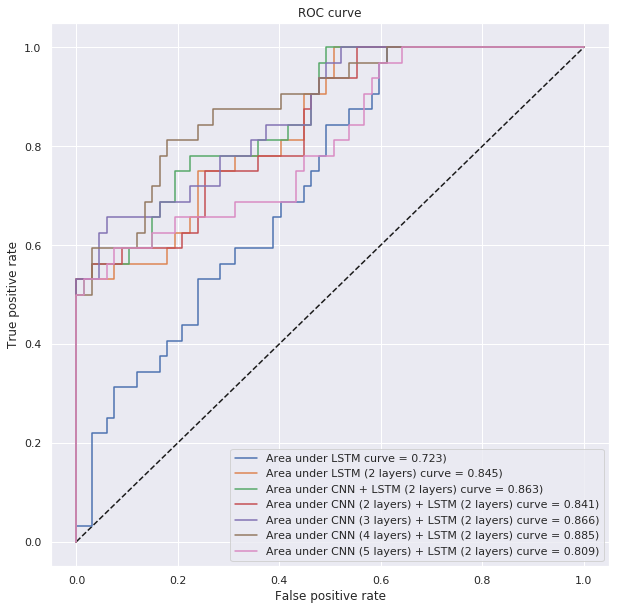

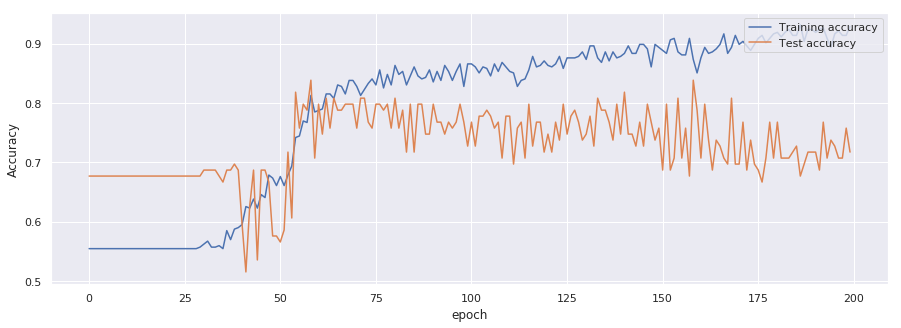

In [44]:

X_train = X_TRAIN[:,0,:].reshape((X_TRAIN.shape[0], X_TRAIN.shape[2], 1))
print('Input training data shape:', X_train.shape)
X_test = X_TEST[:,0,:].reshape((X_TEST.shape[0], X_TEST.shape[2], 1))
print('Test data shape:', X_test.shape)

y_train, y_test = y_TRAIN, y_TEST

epochs, batch_size = 200, 64
filters = 8


model7 = Sequential()

# conv layer 1
model7.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu', 
                  input_shape=(X_train.shape[1],X_train.shape[2])))
model7.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 2
model7.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu'))
model7.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 3
model7.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu'))
model7.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 4
model7.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu'))
model7.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 5
model7.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu'))
model7.add(MaxPooling1D(pool_size=2)) #reduced data size

# LSTM layers
model7.add(LSTM(100, return_sequences=True))
model7.add(Dropout(0.2))
model7.add(LSTM(20))

#output layer
model7.add(Dense(1, activation='sigmoid'))

print(model7.summary())

model7.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']
              )


history7 = model7.fit(X_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size,
                      validation_data=(X_test, y_test)
                     )


# ------------get ROC curve for the model
y_test_pred = model7.predict(X_test).ravel()
fpr_C5L2, tpr_C5L2, thresholds_C5L2 = roc_curve(y_test, y_test_pred)
auc_C5L2 = auc(fpr_C5L2, tpr_C5L2)

fig, ax = plt.subplots(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_L, tpr_L, label='Area under LSTM curve = {:.3f})'.format(auc_L))
plt.plot(fpr_L2, tpr_L2, label='Area under LSTM (2 layers) curve = {:.3f})'.format(auc_L2))
plt.plot(fpr_C1L2, tpr_C1L2, label='Area under CNN + LSTM (2 layers) curve = {:.3f})'.format(auc_C1L2))
plt.plot(fpr_C2L2, tpr_C2L2, label='Area under CNN (2 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C2L2))
plt.plot(fpr_C3L2, tpr_C3L2, label='Area under CNN (3 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C3L2))
plt.plot(fpr_C4L2, tpr_C4L2, label='Area under CNN (4 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C4L2))
plt.plot(fpr_C5L2, tpr_C5L2, label='Area under CNN (5 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C5L2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# accuracy history
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(history7.history['acc'], label='Training accuracy')
plt.plot(history7.history['val_acc'], label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')



plt.show()

# 2 CNN layers (larger kernel size), 2 LSTM layers, 1 feature

Input training data shape: (395, 2000, 1)
Test data shape: (99, 2000, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 2000, 8)           56        
_________________________________________________________________
max_pooling1d_27 (MaxPooling (None, 1000, 8)           0         
_________________________________________________________________
conv1d_28 (Conv1D)           (None, 1000, 8)           392       
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 500, 8)            0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 500, 100)          43600     
_________________________________________________________________
dropout_19 (Dropout)         (None, 500, 100)          0         
_________________________________________________________________
lst

Epoch 51/200
395/395 [==============================] - 3s 7ms/step - loss: 0.4343 - acc: 0.7949 - val_loss: 0.4147 - val_acc: 0.8384
Epoch 52/200
395/395 [==============================] - 3s 7ms/step - loss: 0.4255 - acc: 0.8025 - val_loss: 0.4353 - val_acc: 0.7475
Epoch 53/200
395/395 [==============================] - 3s 7ms/step - loss: 0.4143 - acc: 0.7848 - val_loss: 0.4229 - val_acc: 0.7475
Epoch 54/200
395/395 [==============================] - 2s 6ms/step - loss: 0.4048 - acc: 0.7873 - val_loss: 0.4470 - val_acc: 0.7273
Epoch 55/200
395/395 [==============================] - 2s 6ms/step - loss: 0.4080 - acc: 0.7949 - val_loss: 0.4288 - val_acc: 0.7576
Epoch 56/200
395/395 [==============================] - 3s 6ms/step - loss: 0.4047 - acc: 0.7823 - val_loss: 0.4294 - val_acc: 0.7475
Epoch 57/200
395/395 [==============================] - 2s 6ms/step - loss: 0.3961 - acc: 0.8025 - val_loss: 0.4128 - val_acc: 0.7677
Epoch 58/200
395/395 [==============================] - 2s 6ms

395/395 [==============================] - 2s 6ms/step - loss: 0.2909 - acc: 0.8380 - val_loss: 0.4248 - val_acc: 0.7374
Epoch 113/200
395/395 [==============================] - 2s 6ms/step - loss: 0.2933 - acc: 0.8532 - val_loss: 0.4051 - val_acc: 0.7778
Epoch 114/200
395/395 [==============================] - 2s 6ms/step - loss: 0.2795 - acc: 0.8709 - val_loss: 0.4413 - val_acc: 0.7576
Epoch 115/200
395/395 [==============================] - 2s 6ms/step - loss: 0.2837 - acc: 0.8557 - val_loss: 0.3939 - val_acc: 0.7879
Epoch 116/200
395/395 [==============================] - 2s 6ms/step - loss: 0.3052 - acc: 0.8329 - val_loss: 0.4297 - val_acc: 0.7172
Epoch 117/200
395/395 [==============================] - 2s 6ms/step - loss: 0.2963 - acc: 0.8430 - val_loss: 0.3972 - val_acc: 0.7879
Epoch 118/200
395/395 [==============================] - 2s 6ms/step - loss: 0.2988 - acc: 0.8481 - val_loss: 0.4245 - val_acc: 0.7677
Epoch 119/200
395/395 [==============================] - 3s 7ms/step 

Epoch 173/200
395/395 [==============================] - 2s 6ms/step - loss: 0.2569 - acc: 0.8734 - val_loss: 0.4877 - val_acc: 0.6869
Epoch 174/200
395/395 [==============================] - 2s 6ms/step - loss: 0.2434 - acc: 0.8835 - val_loss: 0.5091 - val_acc: 0.7576
Epoch 175/200
395/395 [==============================] - 2s 6ms/step - loss: 0.2345 - acc: 0.8861 - val_loss: 0.5495 - val_acc: 0.7172
Epoch 176/200
395/395 [==============================] - 2s 6ms/step - loss: 0.2447 - acc: 0.8759 - val_loss: 0.5365 - val_acc: 0.7374
Epoch 177/200
395/395 [==============================] - 2s 6ms/step - loss: 0.2245 - acc: 0.8962 - val_loss: 0.5303 - val_acc: 0.7475
Epoch 178/200
395/395 [==============================] - 3s 6ms/step - loss: 0.2060 - acc: 0.8937 - val_loss: 0.6264 - val_acc: 0.6970
Epoch 179/200
395/395 [==============================] - 3s 7ms/step - loss: 0.2168 - acc: 0.8987 - val_loss: 0.6138 - val_acc: 0.7273
Epoch 180/200
395/395 [==============================] 

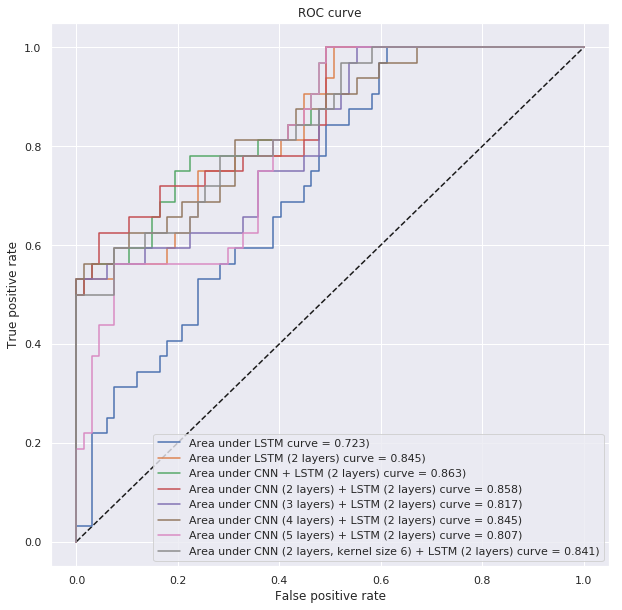

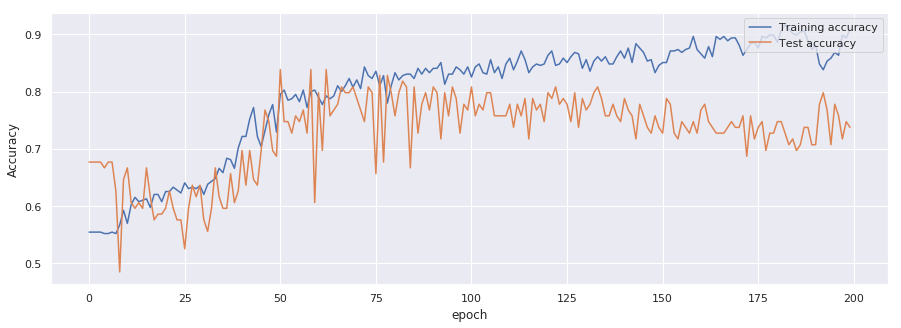

In [37]:

X_train = X_TRAIN[:,0,:].reshape((X_TRAIN.shape[0], X_TRAIN.shape[2], 1))
print('Input training data shape:', X_train.shape)
X_test = X_TEST[:,0,:].reshape((X_TEST.shape[0], X_TEST.shape[2], 1))
print('Test data shape:', X_test.shape)

y_train, y_test = y_TRAIN, y_TEST

epochs, batch_size = 200, 64
filters = 8


model8 = Sequential()

# conv layer 1
model8.add(Conv1D(filters=filters, kernel_size=6, padding='same', 
                  activation='relu', 
                  input_shape=(X_train.shape[1],X_train.shape[2])))
model8.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 2
model8.add(Conv1D(filters=filters, kernel_size=6, padding='same', 
                  activation='relu'))
model8.add(MaxPooling1D(pool_size=2)) #reduced data size


# LSTM layers
model8.add(LSTM(100, return_sequences=True))
model8.add(Dropout(0.2))
model8.add(LSTM(20))

#output layer
model8.add(Dense(1, activation='sigmoid'))

print(model8.summary())

model8.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']
              )


history8 = model8.fit(X_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size,
                      validation_data=(X_test, y_test)
                     )


# ------------get ROC curve for the model
y_test_pred = model8.predict(X_test).ravel()
fpr_C2aL2, tpr_C2aL2, thresholds_C2aL2 = roc_curve(y_test, y_test_pred)
auc_C2aL2 = auc(fpr_C2aL2, tpr_C2aL2)

fig, ax = plt.subplots(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_L, tpr_L, label='Area under LSTM curve = {:.3f})'.format(auc_L))
plt.plot(fpr_L2, tpr_L2, label='Area under LSTM (2 layers) curve = {:.3f})'.format(auc_L2))
plt.plot(fpr_C1L2, tpr_C1L2, label='Area under CNN + LSTM (2 layers) curve = {:.3f})'.format(auc_C1L2))
plt.plot(fpr_C2L2, tpr_C2L2, label='Area under CNN (2 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C2L2))
plt.plot(fpr_C3L2, tpr_C3L2, label='Area under CNN (3 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C3L2))
plt.plot(fpr_C4L2, tpr_C4L2, label='Area under CNN (4 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C4L2))
plt.plot(fpr_C5L2, tpr_C5L2, label='Area under CNN (5 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C5L2))
plt.plot(fpr_C2aL2, tpr_C2aL2, label='Area under CNN (2 layers, kernel size 6) + LSTM (2 layers) curve = {:.3f})'.format(auc_C2aL2))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# accuracy history
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(history8.history['acc'], label='Training accuracy')
plt.plot(history8.history['val_acc'], label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')



plt.show()

# 2 CNN layers, 2 LSTM layers, 2 features
Dipole tilt and the relative magnitude of dipole compared to other modes (upto spherical harmonic degree 11)

Input training data shape: (395, 2000, 2)
Test data shape: (99, 2000, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_49 (Conv1D)           (None, 2000, 8)           56        
_________________________________________________________________
max_pooling1d_49 (MaxPooling (None, 1000, 8)           0         
_________________________________________________________________
conv1d_50 (Conv1D)           (None, 1000, 8)           200       
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 500, 8)            0         
_________________________________________________________________
lstm_55 (LSTM)               (None, 500, 100)          43600     
_________________________________________________________________
dropout_27 (Dropout)         (None, 500, 100)          0         
_________________________________________________________________
lst

Epoch 51/150
395/395 [==============================] - 3s 8ms/step - loss: 0.6871 - acc: 0.5544 - val_loss: 0.6581 - val_acc: 0.6768
Epoch 52/150
395/395 [==============================] - 3s 7ms/step - loss: 0.6872 - acc: 0.5544 - val_loss: 0.6569 - val_acc: 0.6768
Epoch 53/150
395/395 [==============================] - 3s 6ms/step - loss: 0.6865 - acc: 0.5544 - val_loss: 0.6620 - val_acc: 0.6768
Epoch 54/150
395/395 [==============================] - 3s 7ms/step - loss: 0.6869 - acc: 0.5544 - val_loss: 0.6671 - val_acc: 0.6768
Epoch 55/150
395/395 [==============================] - 3s 7ms/step - loss: 0.6872 - acc: 0.5544 - val_loss: 0.6674 - val_acc: 0.6768
Epoch 56/150
395/395 [==============================] - 3s 6ms/step - loss: 0.6870 - acc: 0.5544 - val_loss: 0.6648 - val_acc: 0.6768
Epoch 57/150
395/395 [==============================] - 3s 6ms/step - loss: 0.6868 - acc: 0.5544 - val_loss: 0.6611 - val_acc: 0.6768
Epoch 58/150
395/395 [==============================] - 3s 6ms

395/395 [==============================] - 2s 6ms/step - loss: 0.6886 - acc: 0.5544 - val_loss: 0.6608 - val_acc: 0.6768
Epoch 113/150
395/395 [==============================] - 2s 6ms/step - loss: 0.7059 - acc: 0.5595 - val_loss: 0.6529 - val_acc: 0.6768
Epoch 114/150
395/395 [==============================] - 2s 6ms/step - loss: 0.6988 - acc: 0.5063 - val_loss: 0.6382 - val_acc: 0.6768
Epoch 115/150
395/395 [==============================] - 3s 7ms/step - loss: 0.6932 - acc: 0.5544 - val_loss: 0.6840 - val_acc: 0.6768
Epoch 116/150
395/395 [==============================] - 2s 6ms/step - loss: 0.7030 - acc: 0.4481 - val_loss: 0.6870 - val_acc: 0.6768
Epoch 117/150
395/395 [==============================] - 3s 7ms/step - loss: 0.6897 - acc: 0.5418 - val_loss: 0.6550 - val_acc: 0.6768
Epoch 118/150
395/395 [==============================] - 2s 6ms/step - loss: 0.6861 - acc: 0.5544 - val_loss: 0.6547 - val_acc: 0.6768
Epoch 119/150
395/395 [==============================] - 2s 6ms/step 

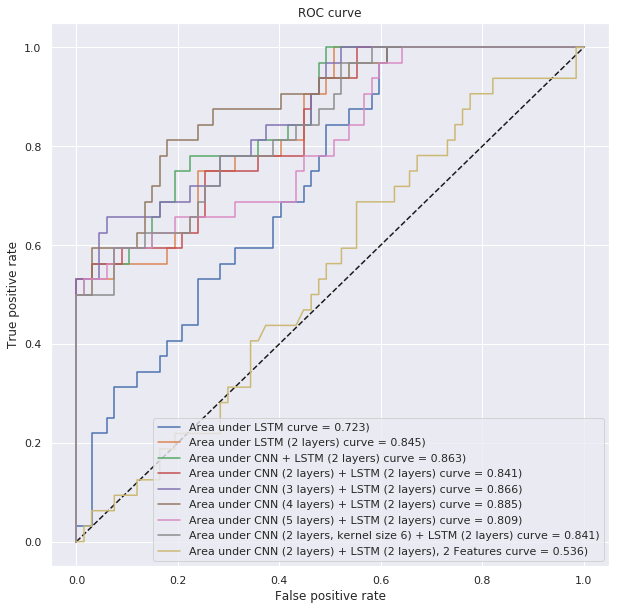

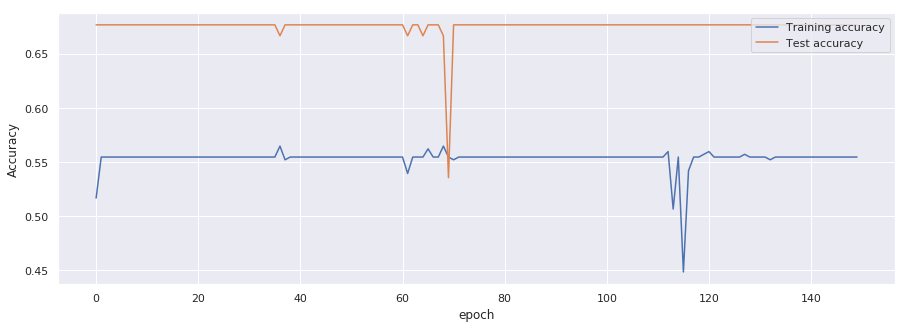

In [45]:

X_train = X_TRAIN.reshape((X_TRAIN.shape[0], X_TRAIN.shape[2], X_TRAIN.shape[1]))
print('Input training data shape:', X_train.shape)
X_test = X_TEST.reshape((X_TEST.shape[0], X_TEST.shape[2], X_TEST.shape[1]))
print('Test data shape:', X_test.shape)

y_train, y_test = y_TRAIN, y_TEST

epochs, batch_size = 150, 64
filters = 8


model9 = Sequential()

# conv layer 1
model9.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu', 
                  input_shape=(X_train.shape[1],X_train.shape[2])))
model9.add(MaxPooling1D(pool_size=2)) #reduced data size

# conv layer 2
model9.add(Conv1D(filters=filters, kernel_size=3, padding='same', 
                  activation='relu'))
model9.add(MaxPooling1D(pool_size=2)) #reduced data size


# LSTM layers
model9.add(LSTM(100, return_sequences=True))
model9.add(Dropout(0.2))
model9.add(LSTM(20))

#output layer
model9.add(Dense(1, activation='sigmoid'))

print(model9.summary())

model9.compile(loss='binary_crossentropy', 
               optimizer='adam', 
               metrics=['accuracy']
              )


history9 = model9.fit(X_train, y_train, 
                      epochs=epochs, 
                      batch_size=batch_size,
                      validation_data=(X_test, y_test)
                     )


# ------------get ROC curve for the model
y_test_pred = model9.predict(X_test).ravel()
fpr_C2L2_2F, tpr_C2L2_2F, thresholds_C2L2_2F = roc_curve(y_test, y_test_pred)
auc_C2L2_2F = auc(fpr_C2L2_2F, tpr_C2L2_2F)

fig, ax = plt.subplots(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_L, tpr_L, label='Area under LSTM curve = {:.3f})'.format(auc_L))
plt.plot(fpr_L2, tpr_L2, label='Area under LSTM (2 layers) curve = {:.3f})'.format(auc_L2))
plt.plot(fpr_C1L2, tpr_C1L2, label='Area under CNN + LSTM (2 layers) curve = {:.3f})'.format(auc_C1L2))
plt.plot(fpr_C2L2, tpr_C2L2, label='Area under CNN (2 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C2L2))
plt.plot(fpr_C3L2, tpr_C3L2, label='Area under CNN (3 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C3L2))
plt.plot(fpr_C4L2, tpr_C4L2, label='Area under CNN (4 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C4L2))
plt.plot(fpr_C5L2, tpr_C5L2, label='Area under CNN (5 layers) + LSTM (2 layers) curve = {:.3f})'.format(auc_C5L2))
plt.plot(fpr_C2aL2, tpr_C2aL2, label='Area under CNN (2 layers, kernel size 6) + LSTM (2 layers) curve = {:.3f})'.format(auc_C2aL2))
plt.plot(fpr_C2L2_2F, tpr_C2L2_2F, label='Area under CNN (2 layers) + LSTM (2 layers), 2 Features curve = {:.3f})'.format(auc_C2L2_2F))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')

# accuracy history
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(history9.history['acc'], label='Training accuracy')
plt.plot(history9.history['val_acc'], label='Test accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='upper right')



plt.show()